# Model Evaluation and Hyperparameter Tuning

CSI 4106 - Fall 2024

Marcel Turcotte  
Version: Sep 29, 2024 16:07

# Preamble

## Quote of the Day

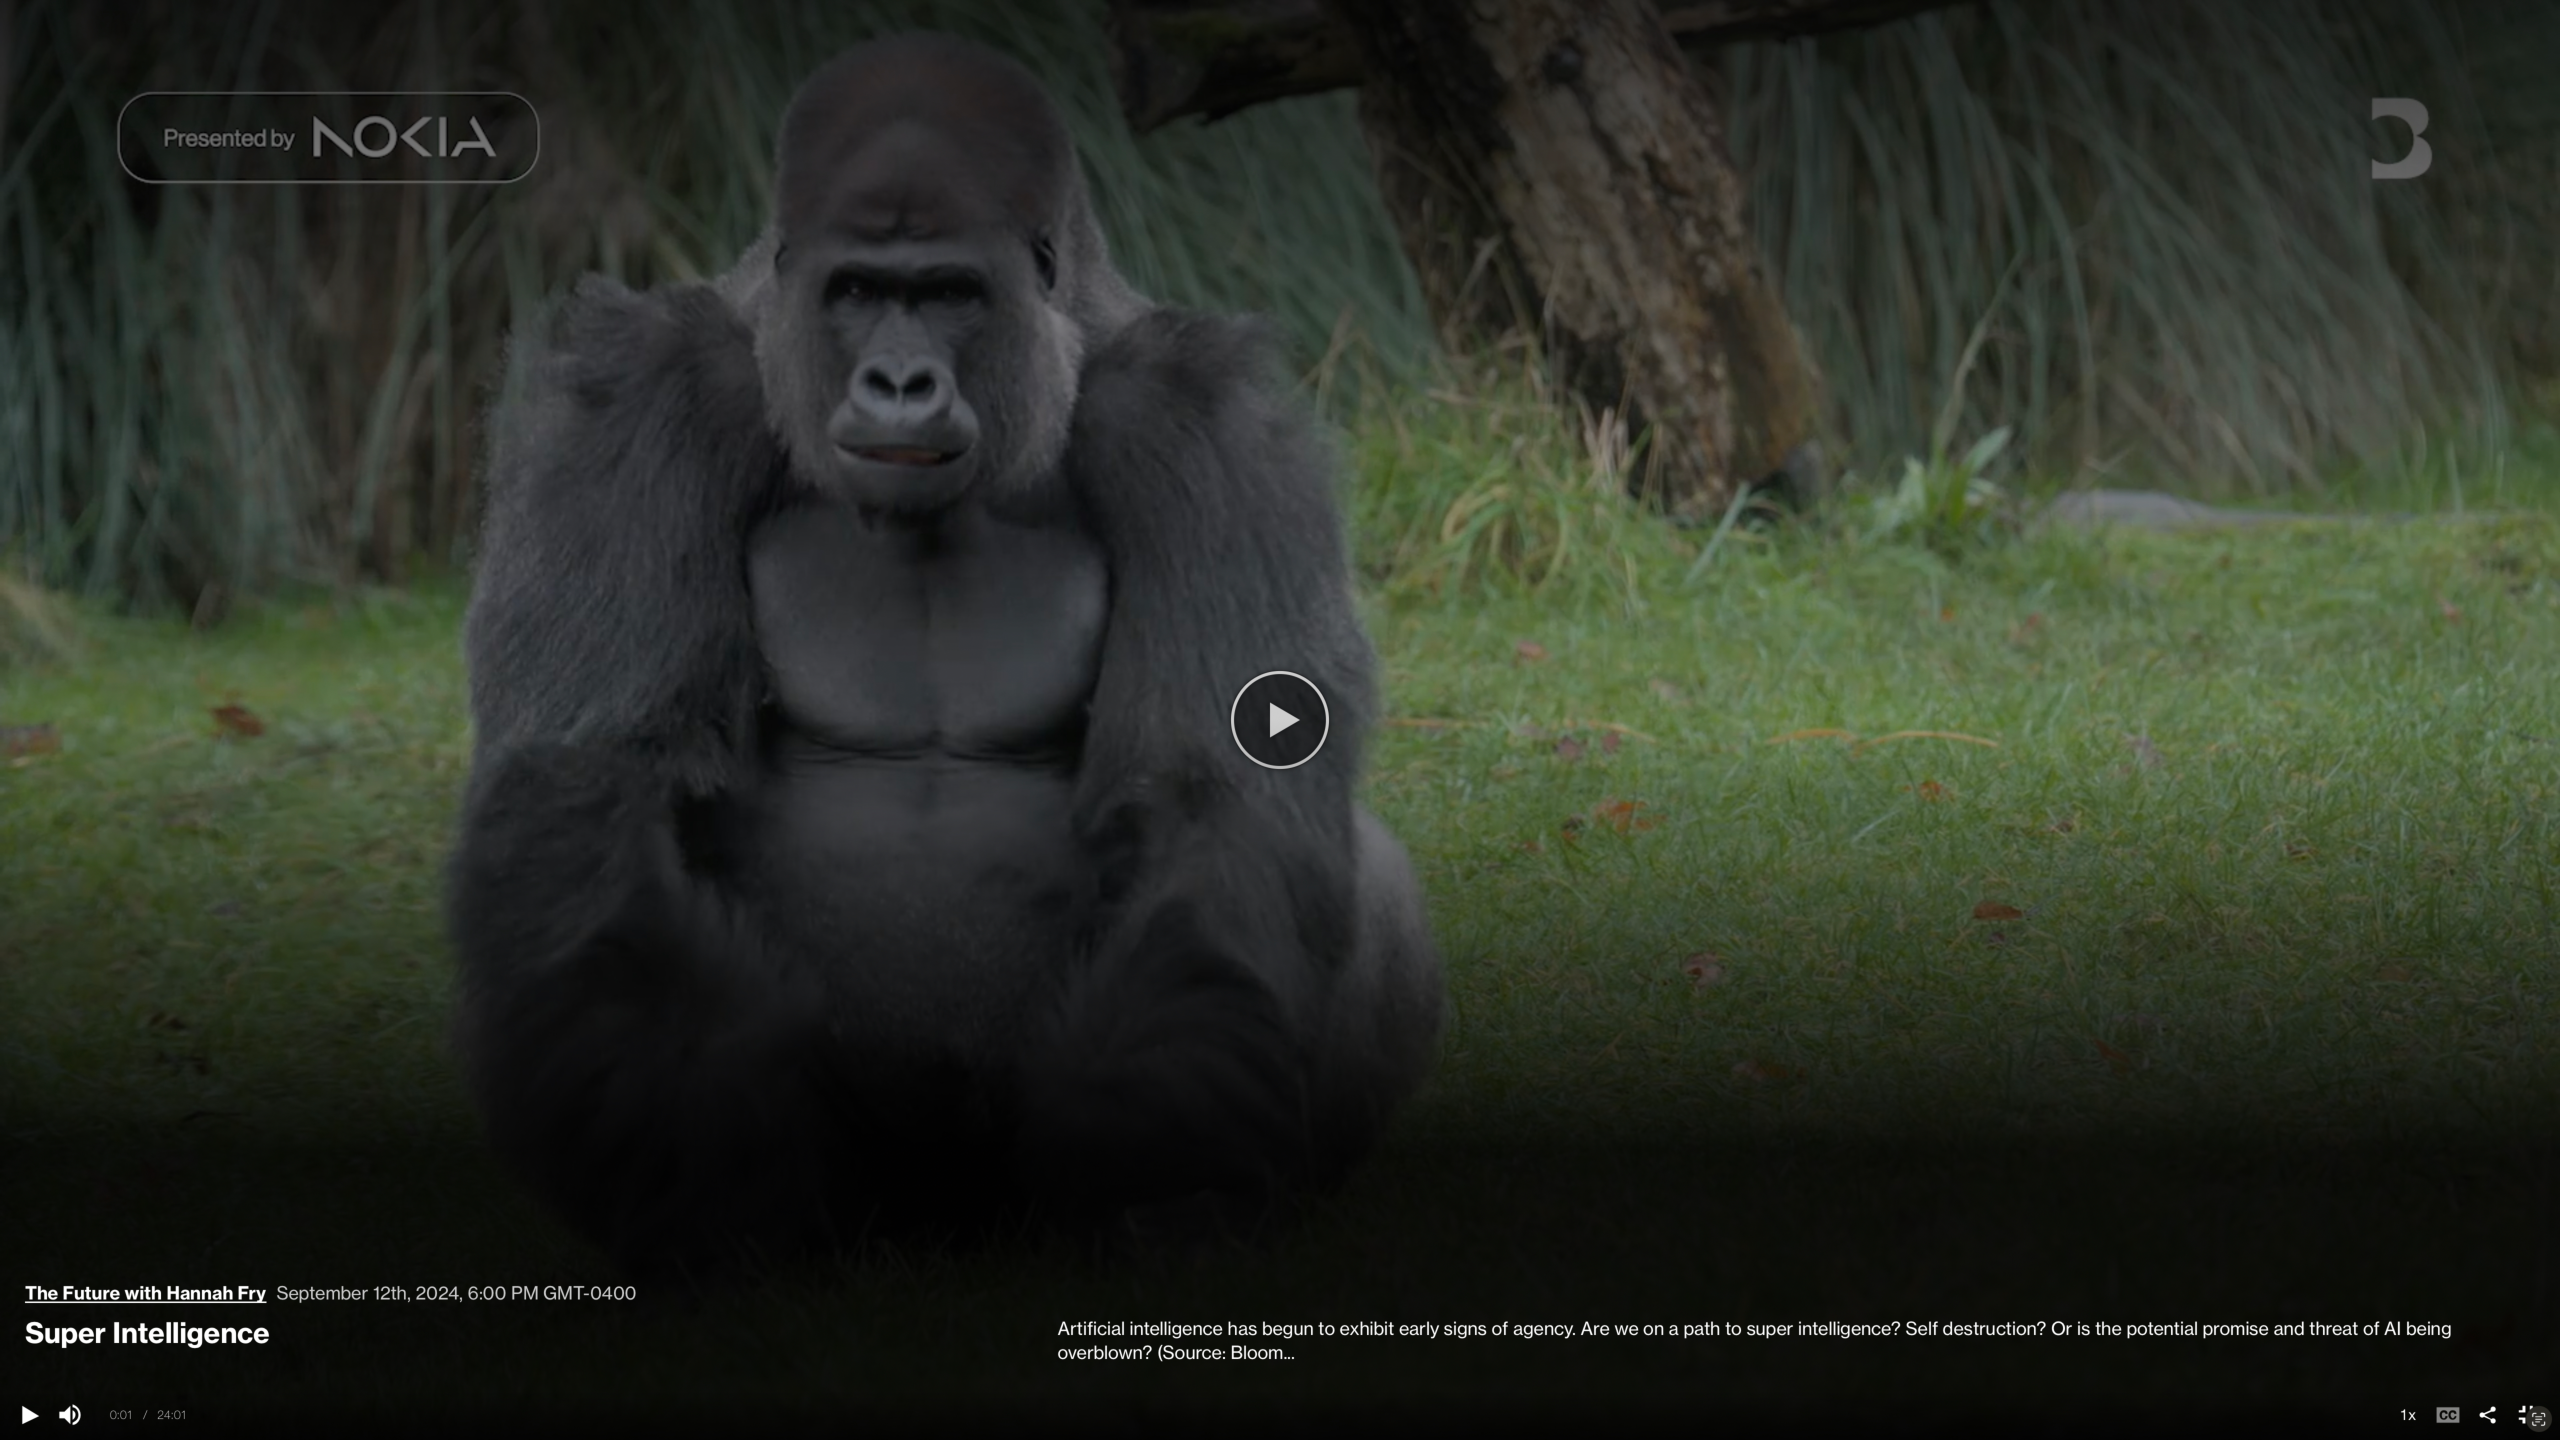

[Super
Intelligence](https://www.bloomberg.com/news/videos/2024-09-12/super-intelligence-the-future-with-hannah-fry-video)
from [The Future with Hannah
Fry](https://www.bloomberg.com/originals/series/the-future-hannah-fry)
aired September 12th, 2024.

## Learning Objectives

1.  **Understand the Purpose of Data Splitting:**
    -   Describe the roles of the training, validation, and test sets in
        model evaluation.
    -   Explain why and how datasets are divided for effective model
        training and evaluation.
2.  **Explain Cross-Validation Techniques:**
    -   Define cross-validation and its importance in model evaluation.
    -   Illustrate the process of $k$-fold cross-validation and its
        advantages over a single train-test split.
    -   Discuss the concepts of underfitting and overfitting in the
        context of cross-validation.
3.  **Hyperparameter Tuning:**
    -   Explain the difference between model parameters and
        hyperparameters.
    -   Describe methods for tuning hyperparameters, including grid
        search and randomized search.
    -   Implement hyperparameter tuning using `GridSearchCV` in
        scikit-learn.
4.  **Evaluate Model Performance:**
    -   Interpret cross-validation results and understand metrics like
        mean and standard deviation of scores.
    -   Discuss how cross-validation helps in assessing model
        generalization and reducing variability.
5.  **Data Size and Its Impact:**
    -   Recognize the influence of dataset size on model performance.
    -   Discuss the concept of data augmentation and its role in
        improving model robustness.
    -   Explore the “unreasonable effectiveness of data” in machine
        learning.
6.  **Feature Engineering and Encoding:**
    -   Explain the importance of feature extraction and the role of
        domain knowledge.
    -   Compare different methods for encoding categorical data, such as
        one-hot encoding and ordinal encoding.
    -   Justify the choice of encoding methods based on the nature of
        the data and the problem.
7.  **Data Preprocessing Techniques:**
    -   Apply normalization and standardization for feature scaling.
    -   Decide when to use normalization versus standardization based on
        data characteristics.
    -   Handle missing values using various imputation strategies and
        understand their implications.
8.  **Addressing Class Imbalance:**
    -   Define the class imbalance problem and its impact on model
        performance.
    -   Explore solutions like resampling, algorithmic adjustments, and
        synthetic data generation (e.g., SMOTE).
    -   Understand the importance of applying these techniques
        appropriately to avoid data leakage.
9.  **Machine Learning Engineering Workflow:**
    -   Outline the steps involved in preparing data for machine
        learning models.
    -   Utilize scikit-learn pipelines for efficient data preprocessing
        and model training.
    -   Emphasize the significance of consistent data transformations
        across training and production environments.
10. **Critical Evaluation of Machine Learning Models:**
    -   Assess the limitations and challenges associated with
        hyperparameter tuning and model selection.
    -   Recognize potential pitfalls in data preprocessing, such as
        incorrect handling of missing values or inconsistent encoding.
    -   Advocate for thorough testing and validation to ensure model
        reliability and generalizability.
11. **Integrate Knowledge in Practical Applications:**
    -   Apply the learned concepts to real-world datasets (e.g., OpenML
        datasets like ‘diabetes’ and ‘adult’).
    -   Interpret and analyze the results of model evaluations and
        experiments.
    -   Develop a comprehensive understanding of the end-to-end machine
        learning pipeline.

The following learning objectives have been generated by OpenAI’s model,
[o1](https://openai.com/index/introducing-openai-o1-preview/), based on
the lecture content.

# Introduction

## Dataset - openml

> ** [www.openml.org](https://www.openml.org)**
>
> OpenML is an open platform for sharing datasets, algorithms, and
> experiments - to learn how to learn better, together.

. . .

In [1]:
import numpy as np
np.random.seed(42)

from sklearn.datasets import fetch_openml

diabetes = fetch_openml(name='diabetes', version=1)
print(diabetes.DESCR)

Today’s dataset is the PIMA dataset, which contains 768 instances and 8
numerical attributes. The numerical nature of these attributes
facilitates our analysis. Additionally, since the data originates from a
published paper, it likely reflects careful data collection, potentially
leading to robust results, as the authors would have needed high-quality
data to support their publication.

## Dataset - `return_X_y`

`fetch_openml` returns a `Bunch`, a `DataFrame`, or `X` and `y`

In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(name='diabetes', version=1, return_X_y=True)

. . .

Mild imbalance (ratio less than 3 or 4)

In [3]:
print(y.value_counts())

class
tested_negative    500
tested_positive    268
Name: count, dtype: int64

. . .

Converting the target labels to 0 and 1

In [4]:
y = y.map({'tested_negative': 0, 'tested_positive': 1})

# Cross-evaluation

## Training and test set

Sometimes called **holdout method**.

-   **Guideline:** Typically, allocate **80%** of your dataset for
    **training** and reserve the remaining **20%** for testing.

-   **Training Set:** This subset of data is utilized to **train** your
    model.

-   **Test Set:** This is an **independent** subset used exclusively at
    the final stage to assess the model’s performance.

### Common Training and Testing Ratios

1.  **80:20 Split:**
    -   **Training Set:** 80% of the data
    -   **Testing Set:** 20% of the data
    -   This is a widely used default split that provides a balance
        between having enough data to train the model and enough data to
        evaluate its performance.
2.  **90:10 Split:**
    -   **Training Set:** 90% of the data
    -   **Testing Set:** 10% of the data
    -   This split might be used when the dataset is very large,
        ensuring a substantial amount of data for training while still
        having a decent-sized test set.

### Considerations for Choosing the Split Ratio

1.  **Dataset Size:**
    -   For large datasets, a smaller proportion can be reserved for
        testing (e.g., 90:10) since even 10% of a large dataset can
        provide a robust evaluation.
2.  **Model Complexity:**
    -   Complex models with many parameters may require more training
        data to avoid overfitting, suggesting a larger training set.
3.  **Validation Set:**
    -   See discussion below.
4.  **Imbalanced Datasets:**
    -   For imbalanced datasets, it’s essential to ensure that both the
        training and testing sets represent the class distribution
        adequately. **Stratified sampling can be used to maintain the
        class proportions in both sets.**

## Training and test set

**Training Error:**

-   Generally tends to be **low**
-   Achieved by optimizing learning algorithms to minimize error through
    parameter adjustments (e.g., weights)

## Training and test set

**Generalization Error:** The error rate observed when the model is
evaluated on new, unseen data.

## Training and test set

**Underfitting:**

-   **High training error**
-   Model is too simple to capture underlying patterns
-   Poor performance on both training and new data

**Overfitting:**

-   Low training error, but **high generalization error**
-   Model captures noise or irrelevant patterns
-   Poor performance on new, unseen data

## Definition

**Cross-validation** is a method used to evaluate and improve the
performance of machine learning models.

It involves partitioning the dataset into multiple subsets, **training
the model on some subsets** while **validating it on the remaining
ones**.

## k-fold cross-validation

1.  **Divide** the dataset into **$k$ equally sized parts** (folds).
2.  T**raining and validation:**
    -   For each iteration, **one fold is used as the validation set**,
        the remaining **$k$-1 folds are used as the training set**.
3.  **Evaluation:** The model’s performance is evaluated in each
    iteration, resulting in $k$ performance measures.
4.  **Aggregation:** Statistics are calculated based on $k$ performance
    measures.

Common choices for the value of $k$ are 3, 5, 7, and 10.

## 3-Fold Cross-validation

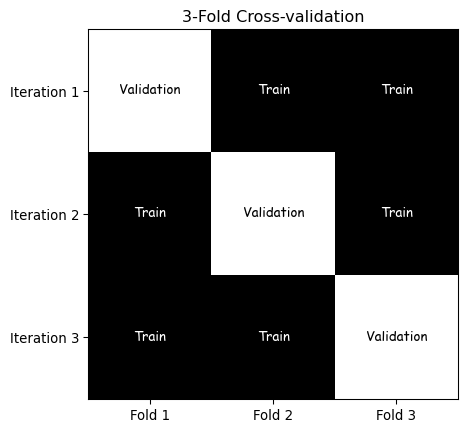

With each iteration, $2/3$ of the dataset is used for training and $1/3$
for validation.

Each row of the table represents an iteration within the $k$-fold
cross-validation process, with the number of iterations equating to the
number of folds. In each iteration, one fold is designated for
validation, while the remaining $k-1$ folds are utilized for training
the model.

## 5-Fold Cross-validation

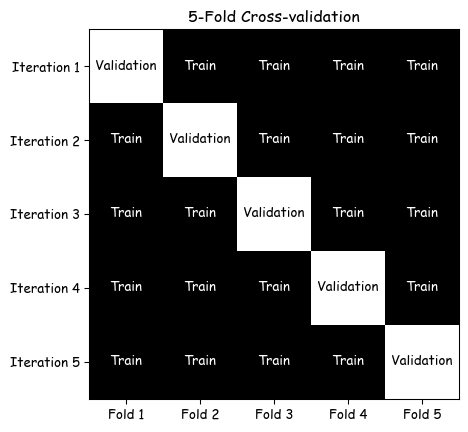

With each iteration, $4/5$ of the dataset is used for training and $1/5$
for validation.

## More Reliable Model Evaluation

-   More **reliable** estimate of model performance compared to a single
    train-test split.
-   **Reduces the variability** associated with a single split, leading
    to a **more stable and unbiased evaluation**.
-   For large values of $k$[1], consider the **average**, **variance**,
    and **confidence interval**.

## Better Generalization

-   Helps in assessing how the model **generalizes** to an independent
    dataset.
-   It ensures that the model’s performance is not overly **optimistic**
    or **pessimistic** by averaging results over multiple folds.

## Efficient Use of Data

-   **Particularly beneficial for small datasets**, cross-validation
    ensures that every data point is used for both training and
    validation.
-   This **maximizes the use of available data**, leading to more
    accurate and reliable model training.

Some examples are more informative for learning algorithms, sometimes
those near the decision boundary.

## Hyperparameter Tuning

-   Commonly used during **hyperparameter tuning**, allowing for the
    **selection of the best model parameters** based on their
    performance across multiple folds.
-   This helps in identifying the **optimal** configuration that
    balances **bias** and **variance**.

## Challenges

-   **Computational Cost**: Requires multiple model trainings.
    -   **Leave-One-Out** (LOO): Extreme case where ( k = N ).
-   **Class Imbalance**: Folds may not represent minority classes.
    -   Use **Stratified Cross-Validation** to maintain class
        proportions.
-   **Complexity**: Error-prone implementation, especially for **nested
    cross-validation**, **bootstraps**, or integration into larger
    pipelines.

Leave-one-out cross-validation (LOO-CV) can lead to overoptimistic
performance evaluation, particularly in certain contexts.

Here’s why:

    1.  **High Variance**: In LOO-CV, each iteration uses almost all the data for training, leaving only one instance for testing. This can result in high variance in the test error across iterations because the model is trained on nearly the full dataset. Since each training set is very similar to the full dataset, it can lead to overly optimistic estimates of generalization error, especially when the dataset is small or the model has high variance (e.g., decision trees or k-nearest neighbors).
    2.  **Overfitting**: Since LOO-CV uses nearly the entire dataset for training in each iteration, complex models (especially ones prone to overfitting) can fit very closely to the data, which might result in a low training error but a misleadingly low test error in some cases.
    3.  **Limited assessment of generalization**: LOO-CV might not give a reliable estimate of how well the model generalizes to completely unseen data because the difference between the training set and the full dataset is minimal, leading to a smaller gap between training and test performance.

In practice, this can make the evaluation appear more optimistic than it
would be with more robust methods like k-fold cross-validation, where
the test sets are larger, and the model has less opportunity to overfit
the training data.

## `cross_val_score`

[1] 10-fold cross-validation.

In [8]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()

from sklearn.model_selection import cross_val_score    

clf_scores = cross_val_score(clf, X, y, cv=5)

print("\nScores:", clf_scores)
print(f"\nMean: {clf_scores.mean():.2f}")
print(f"\nStandard deviation: {clf_scores.std():.2f}")


Scores: [0.71428571 0.66883117 0.71428571 0.79738562 0.73202614]

Mean: 0.73

Standard deviation: 0.04

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html),
see also
[cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).

As previously discussed, a significant limitation of decision trees is
their propensity for overfitting, which leads to high variance when
applied to new datasets. This issue is evident in the observed
performance variability, with accuracy ranging from 67% to 79%, which is
undesirable for achieving robust model generalization.

# Hyperparameter tuning

## Workflow

![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

**Attribution**: [Cross-validation: evaluating estimator
performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

The above image implicitly introduces three categories of data subsets:
**training**, **validation**, and **test**.

## Workflow - implementation

In [9]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(name='diabetes', version=1, return_X_y=True)

y = y.map({'tested_negative': 0, 'tested_positive': 1})

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

To maintain simplicity in these lecture notes, we have not applied any
pre-processing steps.

## Definition

A **hyperparameter** is a configuration **external to the model** that
is **set prior to the training process** and governs the learning
process, influencing model performance and complexity.

The **weights of a model**, which are learned by the learning algorithm,
are often referred to as the **model’s parameters**. To avoid confusion,
**user-defined parameters**, such as the learning rate $\alpha$, are
termed **hyperparameters**. Unlike model parameters, hyperparameters are
*not* learned by the learning algorithm.

## Hyperparameters - Decision Tree

-   `criterion`: `gini`, `entropy`, `log_loss`, measure the quality of a
    split.
-   `max_depth`: limits the **number of levels** in the tree to prevent
    overfitting.

**See**:
[DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

## Hyperparameters - Logistic Regression

-   `penalty`: `l1` or `l2`, helps in preventing overfitting.
-   `solver`: `liblinear`, `newton-cg`, `lbfgs`, `sag`, `saga`.
-   `max_iter`: maximum number of iterations taken for the solvers to
    converge.
-   `tol`: stopping criteria, smaller values mean higher precision.

**See**:
[LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)
and
[SGDClassifier](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html).

## Hyperparameters - KNN

-   `n_neighbors`: number of neighbors to use for $k$-neighbors queries.
-   `weights`: `uniform` or `distance`, equal weight or distance-based
    weight.

**See**:
[KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

## Experiment: `max_depth`

In [10]:
for value in [3, 5, 7, None]:

  clf = tree.DecisionTreeClassifier(max_depth=value)

  clf_scores = cross_val_score(clf, X_train, y_train, cv=10)

  print("\nmax_depth = ", value)
  print(f"Mean: {clf_scores.mean():.2f}")
  print(f"Standard deviation: {clf_scores.std():.2f}")


max_depth =  3
Mean: 0.74
Standard deviation: 0.04

max_depth =  5
Mean: 0.76
Standard deviation: 0.04

max_depth =  7
Mean: 0.73
Standard deviation: 0.04

max_depth =  None
Mean: 0.71
Standard deviation: 0.05

## Experiment: `criterion`

In [11]:
for value in ["gini", "entropy", "log_loss"]:

  clf = tree.DecisionTreeClassifier(max_depth=5, criterion=value)

  clf_scores = cross_val_score(clf, X_train, y_train, cv=10)

  print("\ncriterion = ", value)
  print(f"Mean: {clf_scores.mean():.2f}")
  print(f"Standard deviation: {clf_scores.std():.2f}")


criterion =  gini
Mean: 0.76
Standard deviation: 0.04

criterion =  entropy
Mean: 0.75
Standard deviation: 0.05

criterion =  log_loss
Mean: 0.75
Standard deviation: 0.05

For this specific problem and dataset, the `criterion` parameter has a
limited impact on the learning process.

## Experiment: `n_neighbors`

In [12]:
from sklearn.neighbors import KNeighborsClassifier

for value in range(1, 11):

  clf = KNeighborsClassifier(n_neighbors=value)

  clf_scores = cross_val_score(clf, X_train, y_train, cv=10)

  print("\nn_neighbors = ", value)
  print(f"Mean: {clf_scores.mean():.2f}")
  print(f"Standard deviation: {clf_scores.std():.2f}")


n_neighbors =  1
Mean: 0.67
Standard deviation: 0.05

n_neighbors =  2
Mean: 0.71
Standard deviation: 0.03

n_neighbors =  3
Mean: 0.69
Standard deviation: 0.05

n_neighbors =  4
Mean: 0.73
Standard deviation: 0.03

n_neighbors =  5
Mean: 0.72
Standard deviation: 0.03

n_neighbors =  6
Mean: 0.73
Standard deviation: 0.05

n_neighbors =  7
Mean: 0.74
Standard deviation: 0.04

n_neighbors =  8
Mean: 0.75
Standard deviation: 0.04

n_neighbors =  9
Mean: 0.73
Standard deviation: 0.05

n_neighbors =  10
Mean: 0.73
Standard deviation: 0.04

## Experiment: `weights`

In [13]:
from sklearn.neighbors import KNeighborsClassifier

for value in ["uniform", "distance"]:

  clf = KNeighborsClassifier(n_neighbors=5, weights=value)

  clf_scores = cross_val_score(clf, X_train, y_train, cv=10)

  print("\nweights = ", value)
  print(f"Mean: {clf_scores.mean():.2f}")
  print(f"Standard deviation: {clf_scores.std():.2f}")


weights =  uniform
Mean: 0.72
Standard deviation: 0.03

weights =  distance
Mean: 0.73
Standard deviation: 0.04

For this specific problem and dataset, the `weights` parameter has a
limited impact on the learning process.

At this point, you might hypothesize that certain combinations of
hyperparameters could be more optimal than others.

## Hyperparameter Tuning: Grid Search

-   **Many hyperparameters** need tuning

    -   Major **disadvantage** of ML algorithms

-   **Manual exploration** of combinations is tedious

-   **Grid search** is more systematic

    1.  **Enumerate all** possible hyperparameter combinations

    2.  Train on training set, evaluate on validation set

**Initially**, try powers of 2 or 10. Next, **refine** with grid search
near optimal values if time permits.

The **training set** referred to here is **different** from the one
previously mentioned. In each iteration of the $k$-fold cross-validation
process, a **unique** **training** and **validation set** is created.

In some contexts, the **choice of the model** itself can be considered a
hyperparameter. For instance, when performing model selection within a
machine learning pipeline, different algorithms (e.g., decision trees,
support vector machines, neural networks) can be treated as
hyperparameters. This approach allows for the selection of the
best-performing model through automated processes such as grid search or
random search, alongside the tuning of other hyperparameters.

Thus, while traditionally hyperparameters refer to settings within a
specific model, the model choice can also be incorporated into
hyperparameter optimization frameworks.

As will be discussed later, the choice of the **number of layers** and
the **number of nodes** are often considered hyperparameters when
training **deep learning** algorithms.

## `GridSearchCV`

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'max_depth': range(1, 10),
   'criterion': ["gini", "entropy", "log_loss"]}
]

clf = tree.DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

(grid_search.best_params_, grid_search.best_score_)

({'criterion': 'gini', 'max_depth': 5}, 0.7481910124074653)

## GridSearchCV

In [15]:
param_grid = [
  {'n_neighbors': range(1, 15),
   'weights': ["uniform", "distance"]}
]

clf = KNeighborsClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

(grid_search.best_params_, grid_search.best_score_)

({'n_neighbors': 14, 'weights': 'uniform'}, 0.7554165363361485)

The variable `param_grid` contains a dictionary specifying the names of
the parameters to be tuned, along with the respective values to be
tested.

In this instance, the parameters `n_neighbors` and `weights` are being
tuned. However, additional parameters could be included if necessary.

## `GridSearchCV`

In [17]:
from sklearn.linear_model import LogisticRegression

# 2 * 5 * 5 * 3 = 150 tests!

param_grid = [
  {'penalty': ["l1", "l2"],
   'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
   'max_iter' : [100, 200, 400, 800, 1600],
   'tol' : [0.01, 0.001, 0.0001]}
]

clf = LogisticRegression()

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

(grid_search.best_params_, grid_search.best_score_)

({'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.001},
 0.7756646856427901)

## Randomized Search

-   **Large number of combinations **(many hyperparameters, many values)
-   Use **RandomizedSearchCV**:
    -   Supply **list of values** or **probability distribution** for
        hyperparameters
    -   Specify **number of iterations** (combinations to try)
    -   Predictable **execution time**

**See**: [Comparing randomized search and grid search for hyperparameter
estimation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html).

## Workflow

![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

**Attribution**: [Cross-validation: evaluating estimator
performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

As the ongoing example illustrates, in addition to evaluating various
hyperparameter values, multiple models can also be tested.

## Finally, we proceed with testing

In [18]:
clf = LogisticRegression(max_iter=100, penalty='l2', solver='newton-cg', tol=0.001)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        52
           1       0.64      0.64      0.64        25

    accuracy                           0.77        77
   macro avg       0.73      0.73      0.73        77
weighted avg       0.77      0.77      0.77        77


It appears that we are facing a **class imbalance issue**, which should
have been identified earlier in our workflow!

# Data

## Size does matter

“However, these results suggest that we may want to reconsider the
trade-off between spending time and money on algorithm development
versus **spending it on corpus development** algorithms themselves.”

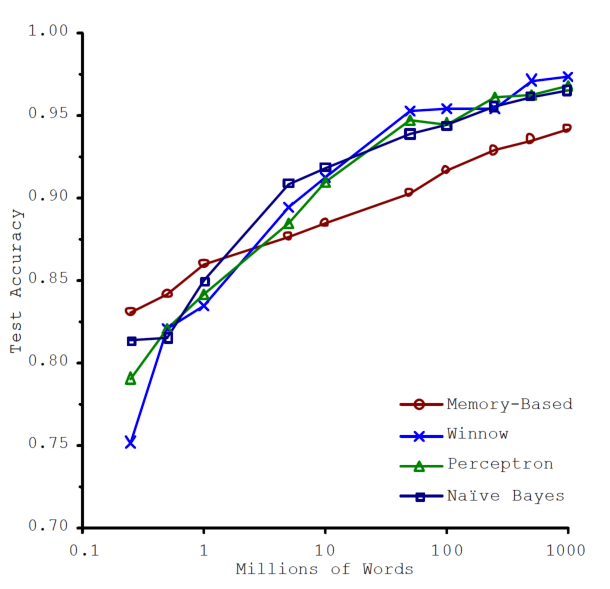

**Attribution**: Banko and Brill (2001)

## Unreasonable Effectiveness of Data

<https://youtu.be/yvDCzhbjYWs>

Halevy, Norvig, and Pereira (2009) and Kaplan et al. (2020).

Peter Norvig’s presentation, titled “The Unreasonable Effectiveness of
Data,” runs for just over one hour. It is noteworthy that the paper on
which the presentation is based was published in 2009, predating the
success of AlexNet.

The substantial improvements observed with AlexNet in 2012 highlighted
the benefits of training deep neural networks on large image datasets.

Similarly, modern models like GPT, Gemini, Claude, and LLaMA have
achieved significant advancements in language capabilities by training
on vast amounts of text data, encompassing nearly all written material
since the inception of human civilization.

**Neural scaling laws** describe how the performance of neural networks
varies with changes in key factors such as dataset size, number of
parameters, and computational cost Kaplan et al. (2020).

## Definition

**Data augmentation** is a technique used to increase the diversity of a
dataset by applying various transformations to the existing data.

**Purpose**: Enhance the robustness and generalization capability of
machine learning models.

## Data Augmentation

**For Images**: Rotations, translations, scaling, flipping, adding
noise, etc.

**For Text**: Synonym replacement, random insertion, deletion, and
swapping of words.

**Generative Adversarial Networks (GANs)** (a form of deep learning) can
be used to generate new, synthetic data that mimics the distribution of
the original dataset. See also: Shumailov et al. (2024).

# Machine Learning Engineering

## Machine Learning Engineering

1.  Gather **adequate** data.
2.  Extract **features** from the raw data:
    -   This process is **labor-intensive**.
    -   It necessitates **creativity**.
    -   **Domain knowledge** is highly beneficial.

## Dataset - Adult

In [19]:
import numpy as np
np.random.seed(42)

from sklearn.datasets import fetch_openml

adult = fetch_openml(name='adult', version=2)
print(adult.DESCR)

Today’s dataset is the PIMA dataset, which contains 768 instances and 8
numerical attributes. The numerical nature of these attributes
facilitates our analysis. Additionally, since the data originates from a
published paper, it likely reflects careful data collection, potentially
leading to robust results, as the authors would have needed high-quality
data to support their publication.

## Adult - Workclass

In [20]:
adult.data['workclass'].unique()

['Private', 'Local-gov', NaN, 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']
Categories (8, object): ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

## Adult - Education

In [21]:
adult.data['education'].unique()

['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool']
Length: 16
Categories (16, object): ['10th', '11th', '12th', '1st-4th', ..., 'Masters', 'Preschool', 'Prof-school', 'Some-college']

## Adult - Marital Status

In [22]:
adult.data['marital-status'].unique()

['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse']
Categories (7, object): ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

## Categorical Data

**Key Points on Data Representation**

-   **Numerical Representation**: Some learning algorithms require data
    to be in numerical form.
-   **Example Attribute**: Consider the `workclass` attribute, which has
    8 distinct values like ‘Federal-gov’, ‘Local-gov’, and so on.

## Encoding Methods

**Which** encoding method is preferable and **why?**

1.  `w` = 1, 2, 3, 4, 5, 6, 7, or 8
2.  `w` = \[0,0,0\], \[0,0,1\], \[0,1,0\], $\ldots$, or \[1,1,1\]
3.  `w` = \[1,0,0,0,0,0,0,0\], \[0,1,0,0,0,0,0,0\], $\ldots$, or
    \[0,0,0,0,0,0,0,1\]

## Encoding for Categorical Data

**One-Hot Encoding**: This method should be preferred for categorical
data.

-   **Increases Dimensionality**: One-hot encoding increases the
    dimensionality of feature vectors.
-   **Avoids Bias**: Other encoding methods can introduce biases.
-   **Example of Bias**: Using the first method, `w` = 1, 2, 3, etc.,
    implies that ‘Federal-gov’ and ‘Local-gov’ are similar, while
    ‘Federal-gov’ and ‘Without-pay’ are not.
-   **Misleading Similarity**: The second method, `w` = \[0,0,0\],
    \[0,0,1\], etc., might mislead the algorithm by suggesting
    similarity based on numeric patterns.

## Definition

**One-Hot Encoding**: A technique that converts categorical variables
into a binary vector representation, where each category is represented
by a vector with a single ‘1’ and all other elements as ‘0’.

Later, we will consider another encoding called an **embedding**.

## OneHotEncoder

In [23]:
from numpy import array
from sklearn.preprocessing import OneHotEncoder

work = adult.data[['workclass']]

onehot_encoder = OneHotEncoder()

onehot_encoder.fit(work)
values_encoded = onehot_encoder.transform(work)

for i in range(5): print(values_encoded.toarray()[i])

[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1.]

**Consistency is Key**: Ensure you use the same encoding on: Validation
Set, Test Set, and Production Data.

A student from my research group faced a challenging debugging issue.
They mistakenly created a new encoder for the training set using
`onehot_encoder.fit(X_test['some_attribute'])`, which produced a vector
representation different from the one used during training.
Consequently, the results on the training set were poor, while the
results on the test set appeared satisfactory.

While `Pandas` offers a method called `get_dummies()` for one-hot
encoding, it is important to note the following distinctions:

-   **Category Memory**: `OneHotEncoder` retains the categories it was
    trained on, whereas `get_dummies()` does not.
-   **Consistency in Production**: It is crucial to use the same
    encoding scheme in production as was used during training to ensure
    accurate results.
-   **Vector Length Discrepancies**: If `get_dummies()` encounters a
    different number of categories in new data, it will produce vectors
    of varying lengths, leading to potential errors.
-   **Handling Missing Values**: When `get_dummies()` processes missing
    values, it generates an additional column to accommodate them.

Ensuring consistency in encoding across **training**, **validation**,
and **production** datasets is essential to maintain the integrity and
accuracy of your machine learning models.

## Case Study

-   **Dataset**: [Heart
    Disease](https://archive.ics.uci.edu/dataset/45/heart+disease)
    -   **Examples**: 303, **features**: 13, **target**:
        Presence/absence of disease
-   **Categorical Data**:
    -   **sex**: 1 = male, 0 = female
    -   **cp (chest pain type)**:
        -   1: Typical angina
        -   2: Atypical angina
        -   3: Non-anginal pain
        -   4: Asymptomatic
    -   **Other**: ‘fbs’, ‘restecg’, ‘exang’, ‘slope’, ‘thal’

**To simplify the analysis**: Examples with missing values were dropped,
no hyperparameter tuning was performed, numerical values were scaled for
solver convergence.

Here are some suggestions for further investigation:

-   Assess the impact of omitting missing values on the dataset.
-   Implement hyperparameter tuning to determine whether $L_1$ or $L_2$
    regularization enhances model performance.

## Case Study

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the 'Heart-Disease' dataset from OpenML
data = fetch_openml(name='Heart-Disease', version=1, as_frame=True)
df = data.frame

# Replace '?' with NaN and convert columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Define features and target
X = df.drop(columns=['target'])
y = df['target']

# Columns to encode with OneHotEncoder
columns_to_encode = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Identify numerical columns
numerical_columns = X.columns.difference(columns_to_encode)

# Split the dataset into training and testing sets before transformations
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Apply OneHotEncoder and StandardScaler using ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), columns_to_encode),
        ('scaler', StandardScaler(), numerical_columns)
    ]
)

# Fit the transformer on the training data and transform both training and test data
X_train_processed = column_transformer.fit_transform(X_train)
X_test_processed = column_transformer.transform(X_test)

# Initialize and train logistic regression model
model = LogisticRegression(max_iter=1000)
model = model.fit(X_train_processed, y_train)

## Case study - results

In [25]:
# Predict and evaluate the model
y_pred = model.predict(X_test_processed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90        29
         1.0       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61


## Case study - chest pain (cp)

In [26]:
# Retrieve feature names after transformation using get_feature_names_out()
feature_names = column_transformer.get_feature_names_out()

# Get coefficients and map them to feature names
coefficients = model.coef_[0]

# Create a DataFrame with feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Display coefficients associated with 'cp'
cp_features = coef_df[coef_df['Feature'].str.contains('_cp')]
print("\nCoefficients associated with 'cp':")
print(cp_features)


Coefficients associated with 'cp':
          Feature  Coefficient
2  onehot__cp_0.0    -1.013382
3  onehot__cp_1.0    -0.212284
4  onehot__cp_2.0     0.599934
5  onehot__cp_3.0     0.628824

## Case study - coefficients

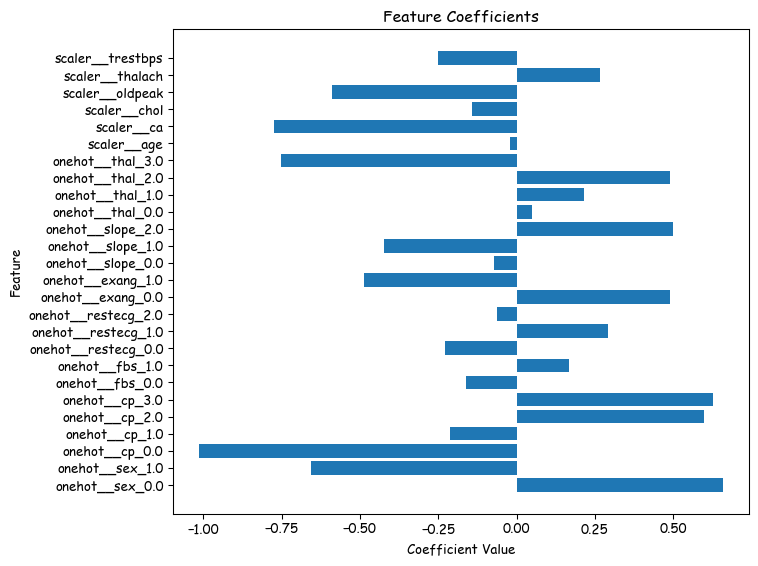

In [27]:
# Visualize the coefficients

plt.figure(figsize=(8, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Positive coefficients** in a logistic regression model signify that
**higher values of the corresponding feature contribute positively** to
the probability of an example **belonging to ‘target = 1.0’**. Negative
coefficients indicate the opposite effect.

## Case study - coefficients (sorted)

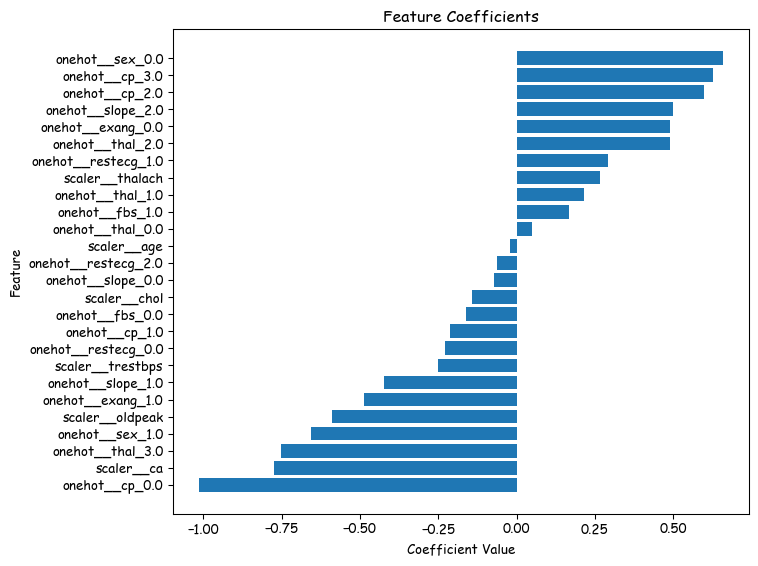

In [28]:
# Visualize the coefficients

plt.figure(figsize=(8, 6))
coef_df.sort_values(by='Coefficient', inplace=True)
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Definition

**Ordinal encoding** is a technique that assigns numerical values to
categorical attributes based on their inherent order or rank.

## Feature Engineering - Ordinal

For attributs with values such as **‘Poor’**, **‘Average’**, and
**‘Good’**, an ordinal encoding would make sense.

. . .

However!

In [29]:
from numpy import array
from sklearn.preprocessing import OrdinalEncoder

X =[['Poor'], ['Average'], ['Good'], ['Average'], ['Average']]

encoder = OrdinalEncoder()

encoder.fit(X)
encoder.transform(X)

array([[2.],
       [0.],
       [1.],
       [0.],
       [0.]])

## OrdinalEncoder (revised)

In [30]:
from numpy import array
from sklearn.preprocessing import OrdinalEncoder

X =[['Poor'], ['Average'], ['Good'], ['Average'], ['Average']]

encoder = OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])

encoder.fit(X)

X_encoded = encoder.transform(X)

X_encoded

array([[0.],
       [1.],
       [2.],
       [1.],
       [1.]])

The desired order of the categories must be explicitly provided to the
encoder; otherwise, it defaults to alphabetical order.

An ordinal encoder is appropriate when categorical attributes have a
clear, inherent order or ranking, such as ‘Low’, ‘Medium’, and ‘High’,
or ‘Poor’, ‘Average’, and ‘Good’. This encoding method preserves the
ordinal relationships among categories.

When data is inherently ordinal, this encoding is more compact and can
be advantageous for machine learning models. However, if there is any
uncertainty about the ordinal nature of the data, it is safer to use a
`OneHotEncoder`.

## Definition

**Discretization** involves grouping ordinal values into discrete
categories.

AKA **binning**, **bucketing**, or **quantization**.

## Feature Engineering: Binning

**Example**: Categorizing ages into bins such as ‘infant’, ‘child’,
‘teen’, ‘adult’, and ‘senior citizen’.

. . .

**Advantages**:

-   Enables the algorithm to learn effectively with fewer training
    examples.

**Disadvantages**:

-   Requires domain expertise to define meaningful categories.
-   May lack generalizability; for example, the starting age for ‘senior
    citizen’ could be 60, 65, or 70[1].

Providing hints or predefined bins can help a decision tree algorithm
generate more compact trees, as it reduces the need for the classifier
to independently learn decision boundaries.

However, introducing such a strong bias may hinder the algorithm’s
ability to discover meaningful decision boundaries on its own.

Cross-validation is an effective method to determine the best encoding
scheme, but it is essential to withhold the test set until the final
evaluation phase of the project to prevent data leakage and ensure
unbiased assessment.

## FunctionTransformer

[1] Your instructor is concerned with your choice of cutoff

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer

bins = [0, 1, 13, 20, 60, np.inf]
labels = ['infant', 'kid', 'teen', 'adult', 'senior citizen']

transformer = FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
)

X = np.array([0.5, 2, 15, 25, 97])
transformer.fit_transform(X)

['infant', 'kid', 'teen', 'adult', 'senior citizen']
Categories (5, object): ['infant' < 'kid' < 'teen' < 'adult' < 'senior citizen']

Se also:
[KBinsDiscretizer](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer)

# Scaling

## Normalization

Learning algorithms perform optimally when feature values have **similar
ranges**, such as \[-1,1\] or \[0,1\].

-   This accelerates optimization (e.g., gradient descent).

**Normalization**: $$
  \frac{x_i^{(j)} - \min^{(j)}}{\max^{(j)} - \min^{(j)}}
$$

**See:**
[sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

## Standardization

Standardization (AKA z-score normalization) transforms each feature to
have a **normal distribution** with a mean ($\mu$) of 0 and a standard
deviation ($\sigma$) of 1.

$$
\frac{x_i^{(j)} - \mu^{(j)}}{\sigma^{(j)}}
$$

**Note**: The range of values is not bounded!

**See:**
[sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

## Standardization or Normalization?

-   Treat scaling as a hyperparameter and **evaluate both**
    normalization and standardization.
-   **Standardization** is generally more robust to **outliers** than
    normalization.
-   Guidelines from Burkov (2019), § 5:
    -   Use **standardization** for **unsupervised learning** tasks.
    -   Use **standardization** if features are approximately **normally
        distributed**.
    -   Prefer **standardization** in the presence of **outliers**.
    -   Otherwise, use **normalization**.

Do you see why standardization is generally more robust to **outliers**
than normalization?

An effective strategy for mitigating the impact of outliers in data is
the application of a logarithmic transformation to the values. This
technique reduces the skewness of the data, thereby diminishing the
disproportionate influence of extreme values.

# Missing Values

## Definition

**Missing values** refer to the absence of data points or entries in a
dataset where a value is expected.

**Age** is a good example, as some patients may withhold their age due
to privacy concerns.

## Handling Missing Values

-   **Drop Examples**
    -   Feasible if the dataset is **large** and **outcome is
        unaffected**.
-   **Drop Features**
    -   Suitable if it **does not impact** the project’s outcome.
-   **Use Algorithms Handling Missing Data**
    -   Example: `XGBoost`
    -   **Note**: Some algorithms like
        `sklearn.linear_model.LinearRegression` **cannot handle**
        missing values.
-   **Data Imputation**
    -   Replace missing values with computed values.

## Definition

**Data imputation** is the process of replacing missing values in a
dataset with substituted values, typically using statistical or machine
learning methods.

## Data Imputation Strategy

Replace missing values with **mean** or **median** of the **attribute**.

In [32]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

X = imputer.fit_transform(X)

. . .

-   **Cons**: Ignores feature correlations and complex relationships.

-   **Mode Imputation**: Replace missing values with the most frequent
    value; also ignores feature correlations.

Data imputation inherently relies on several assumptions, which may not
always hold true.

**Randomness Assumption**: Many methods (e.g., mean/median imputation)
assume that missingness is unrelated to any data.

**Model Bias**: Incorrect randomness assumptions can lead to biased
estimates and flawed conclusions.

**Information Loss**: Imputation can obscure patterns, leading to loss
of valuable information for advanced models.

Proceed with caution!

## Data Imputation Strategy

**Special Value Method**: Replace missing values with a value outside
the normal range (e.g., use -1 or 2 for data normalized between
\[0,1\]).

-   **Objective**: Enable the learning algorithm to recognize and
    appropriately handle missing values.

## Data Imputation Strategy

-   **Middle-Range Imputation**: Replace missing values with a value in
    the middle of the normal range (e.g., use 0 for data distributed in
    the range \[-1,1\]).

    -   **Categorical Data**: Use small non-zero numerical values.
        -   Example: Use \[0.25, 0.25, 0.25, 0.25\] instead of \[1, 0,
            0, 0\] for ‘Poor’, \[0, 1, 0, 0\] for ‘Everage’, \[0, 0, 1,
            0\] for ‘Good’, and \[0, 0, 0, 1\] for ‘Excellent’.
    -   **Objective**: Minimize the impact of imputed values on the
        results.

**Selection of Method**: The effectiveness of imputation methods can
vary, and it is essential to compare multiple techniques to determine
the best approach for your specific dataset.

## Alternative Approach

-   **Problem Definition**: Predict unknown (missing) labels for given
    examples.
-   Have you encountered this kind of problem before?
-   **Relevance**: This can be framed as a supervised learning problem.
    -   Let $\hat{x_i}$ be a new example:
        $[x_i^{(1)}, x_i^{(2)}, \ldots, x_i^{(j-1)}, x_i^{(j+1)}, \ldots, x_i^{(D)}]$.
    -   Let $\hat{y}_i = x_i^{j}$.
    -   **Training Set**: Use examples where $x_i^{j}$ is not missing.
    -   **Method**: Train a classifier on this set to predict (impute)
        the missing values.

## Using ML for Imputation

1.  **Instance-Based Method**:

    -   Use $k$ nearest neighbors (k-NN) to find the $k$ closest
        examples and impute using the non-missing values from the
        neighborhood.

2.  **Model-Based Methods**:

    -   Employ advanced techniques such as random forests, tensor
        decomposition, or deep neural networks.

## Why Use these Methods?

-   **Advantages**:
    -   Effectively handle complex relationships and correlations
        between features.
-   **Disadvantages**:
    -   Cost-intensive in terms of labor, CPU time, and memory
        resources.

# Class Imbalance

## Definition

The **class imbablance problem** is a scenario where the number of
instances in one class significantly outnumbers the instances in other
classes.

. . .

Models tend to be biased towards the **majority class**, leading to
**poor performance on the minority class**.

Standard evaluation metrics like accuracy may be misleading in the
presence of class imbalance.

## Solutions

-   **Resampling:** Techniques such as **oversampling** the minority
    class or **undersampling** the majority class.

-   **Algorithmic Adjustments:** Using cost-sensitive learning or
    modifying decision thresholds.

-   **Synthetic Data:** Generating synthetic samples for the minority
    class using methods like SMOTE (Synthetic Minority Over-sampling
    Technique).

Apply solutions only to the **training set** to prevents **data
leakage**.

Chawla et al. (2002) presents the original work, whereas Pradipta et al.
(2021) is a recent review.

**Oversampling**

-   **Oversampling** can lead to overfitting, especially if the
    synthetic samples are very similar to the existing ones.
-   **Impact**: The model may perform well on training data but
    generalize poorly to unseen data.

**Undersampling**

-   **Loss of Information** reduces the number of instances in the
    majority class.

-   **Impact**: Potentially discards valuable information and can lead
    to underfitting.

-   **Reduced Model Performance**: Smaller training dataset may not
    capture the complexity of the problem.

-   **Impact**: Can result in a less accurate and less robust model.

# Prologue

## Summary

-   **Cross-Validation & Hyperparameter Tuning**: Key for preventing
    overfitting and optimizing performance.
-   **Training Set Size**: Impact on model efficacy and generalization.
-   **Attribute Encoding**: Evaluation of techniques to capture
    biological phenomena.
-   **Preprocessing**:
    -   Data Scaling
    -   Handling Missing Values
    -   Managing Class Imbalance

## Next lecture

-   We will introduce artificial neural networks.

## References

Banko, Michele, and Eric Brill. 2001. “Scaling to Very Very Large
Corpora for Natural Language Disambiguation.” In *Proceedings of the
39th Annual Meeting on Association for Computational Linguistics*,
26–33. ACL ’01. USA: Association for Computational Linguistics.
<https://doi.org/10.3115/1073012.1073017>.

Burkov, Andriy. 2019. *The Hundred-Page Machine Learning Book*. Andriy
Burkov.

Chawla, N V, K W Bowyer, L O Hall, and W P Kegelmeyer. 2002.
“<span class="nocase">SMOTE: Synthetic minority over-sampling
technique</span>.” *Journal of Artificial Intelligence Research* 16:
321–57.

Halevy, Alon, Peter Norvig, and Fernando Pereira. 2009.
“<span class="nocase">The Unreasonable Effectiveness of Data</span>.”
*IEEE Intelligent Systems* 24 (2): 8–12.

Kaplan, Jared, Sam McCandlish, Tom Henighan, Tom B. Brown, Benjamin
Chess, Rewon Child, Scott Gray, Alec Radford, Jeffrey Wu, and Dario
Amodei. 2020. “Scaling Laws for Neural Language Models.”
<https://arxiv.org/abs/2001.08361>.

Pradipta, Gede Angga, Retantyo Wardoyo, Aina Musdholifah, I Nyoman
Hariyasa Sanjaya, and Muhammad Ismail. 2021. “<span class="nocase">SMOTE
for Handling Imbalanced Data Problem : A Review</span>.” *2021 Sixth
International Conference on Informatics and Computing (ICIC)* 00: 1–8.
<https://doi.org/10.1109/icic54025.2021.9632912>.

Russell, Stuart, and Peter Norvig. 2020. *Artificial Intelligence: A
Modern Approach*. 4th ed. Pearson. <http://aima.cs.berkeley.edu/>.

Shumailov, Ilia, Zakhar Shumaylov, Yiren Zhao, Nicolas Papernot, Ross
Anderson, and Yarin Gal. 2024. “<span class="nocase">AI models collapse
when trained on recursively generated data</span>.” *Nature* 631 (8022):
755–59. <https://doi.org/10.1038/s41586-024-07566-y>.

# Appendix: Pipeline

## Pipeline

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
        ])

training_num_tr = num_pipeline.fit_transform(training_num)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), ["sequence"]),
    ])

training_prepared = full_pipeline.fit_transform(training)

------------------------------------------------------------------------

Marcel **Turcotte**

<Marcel.Turcotte@uOttawa.ca>

School of Electrical Engineering and **Computer Science** (EE**CS**)

University of Ottawa